# Read flux power for different models / snapshots / temperatures / tau

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import sys
import os
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 120
mpl.rcParams['figure.dpi'] = 120
import p1d_arxiv

### Specify suite of simulations to use and read metadata

In [2]:
drop_temp=True
drop_tau=True
arxiv_1705=p1d_arxiv.ArxivP1D(basedir='../sim_suites/emulator_512_17052019/',
                              drop_tau_rescalings=drop_tau,drop_temp_rescalings=drop_temp,verbose=True)
arxiv_1506=p1d_arxiv.ArxivP1D(basedir='../sim_suites/emulator_512_15062019/',
                              drop_tau_rescalings=drop_tau,drop_temp_rescalings=drop_temp,verbose=True)
arxiv_1806=p1d_arxiv.ArxivP1D(basedir='../sim_suites/emulator_512_18062019/',
                              drop_tau_rescalings=drop_tau,drop_temp_rescalings=drop_temp,verbose=True)

latin hyper-cube data {'param_space': {'Om_star': {'ip': 0, 'min_val': 0.955, 'max_val': 0.975, 'z_star': 3.0, 'latex': '$\\Omega_\\star$'}, 'Delta2_star': {'ip': 1, 'min_val': 0.25, 'max_val': 0.45, 'z_star': 3.0, 'kp_Mpc': 0.7, 'latex': '$\\Delta^2_\\star$'}, 'n_star': {'ip': 2, 'min_val': -2.35, 'max_val': -2.25, 'z_star': 3.0, 'kp_Mpc': 0.7, 'latex': '$n_\\star$'}, 'alpha_star': {'ip': 3, 'min_val': -0.265, 'max_val': -0.165, 'z_star': 3.0, 'kp_Mpc': 0.7, 'latex': '$\\alpha_\\star$'}, 'mu_He': {'ip': 4, 'min_val': 0.5, 'max_val': 2.0, 'latex': '$\\mu_{\\rm He}$'}, 'mu_H': {'ip': 5, 'min_val': 0.5, 'max_val': 2.0, '   latex': '$\\mu_{\\rm H}$'}}, 'nsamples': 10, 'samples': {'0': [0.972, 0.42000000000000004, -2.315, -0.19, 0.7250000000000001, 1.3250000000000002], '1': [0.96, 0.28, -2.295, -0.2, 1.3250000000000002, 1.475], '2': [0.966, 0.3, -2.305, -0.26, 1.025, 0.875], '3': [0.956, 0.4, -2.275, -0.25, 0.575, 1.175], '4': [0.968, 0.44, -2.325, -0.22, 1.475, 0.7250000000000001], '5': [

In [3]:
def plot_p1d_dependence(arxiv,tag):
    N=len(arxiv.data)
    print('N =',N)
    val=np.array([arxiv.data[i][tag] for i in range(N)])
    imin=np.argmin(val)
    imax=np.argmax(val)
    min_val=val[imin]
    max_val=val[imax]
    plt.figure(figsize=[10,4])
    # first power spectrum for delta_flux
    plt.subplot(1, 2, 1)
    for i in range(N):
        data=arxiv.data[i]
        k_Mpc=data['k_Mpc']
        p1d_Mpc=data['p1d_Mpc']
        col = plt.cm.jet((val[i]-min_val)/(max_val-min_val))
        if i in [imin,imax]:
            label=tag+' = %f'%val[i]
        else:
            label=None
        plt.semilogx(k_Mpc,k_Mpc*p1d_Mpc,color=col,label=label)
    plt.xlabel(r'$k_\parallel$ [1/Mpc]')
    plt.ylabel(r'$k_\parallel \quad P_{\delta}(k_\parallel)$')
    plt.legend()
    plt.title(r'P1D of $\delta_F$ as a function of '+tag)
    # then power spectrum for F  
    plt.subplot(1, 2, 2)
    for i in range(N):
        data=arxiv.data[i]
        k_Mpc=data['k_Mpc']
        p1d_Mpc=data['p1d_Mpc']
        mF=data['mF']
        p1d_Mpc_F = p1d_Mpc * mF**2
        col = plt.cm.jet((val[i]-min_val)/(max_val-min_val))
        if i in [imin,imax]:
            label=tag+' = %f'%val[i]
        else:
            label=None
        plt.semilogx(k_Mpc,k_Mpc*p1d_Mpc_F,color=col,label=label)
    plt.xlabel(r'$k_\parallel$ [1/Mpc]')
    plt.ylabel(r'$k_\parallel \quad P_F(k_\parallel)$')
    plt.legend()
    plt.title(r'P1D of $F$ as a function of '+tag)

N = 130


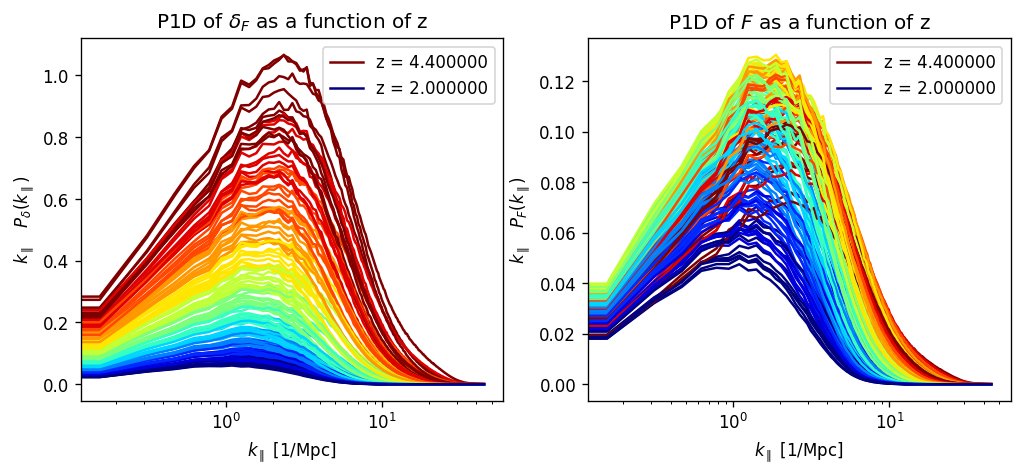

In [4]:
plot_p1d_dependence(arxiv_1705,'z')

N = 78


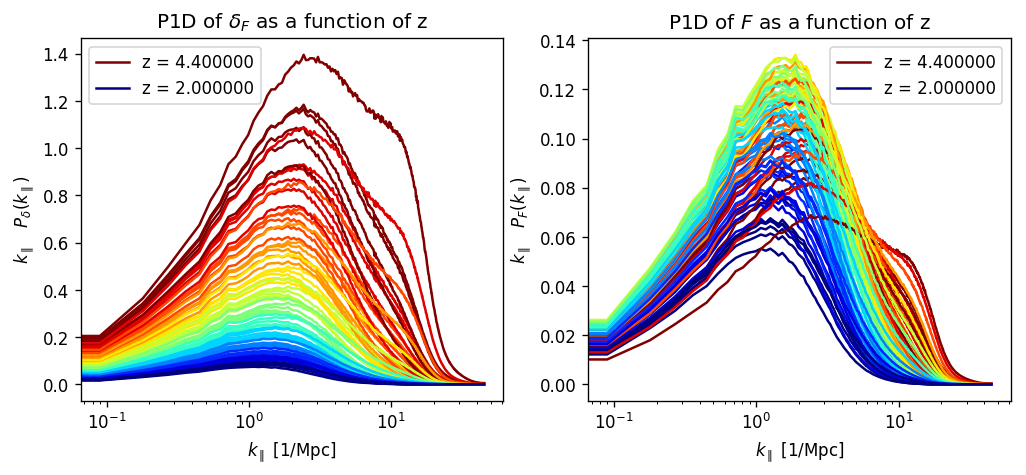

In [5]:
plot_p1d_dependence(arxiv_1506,'z')

N = 78


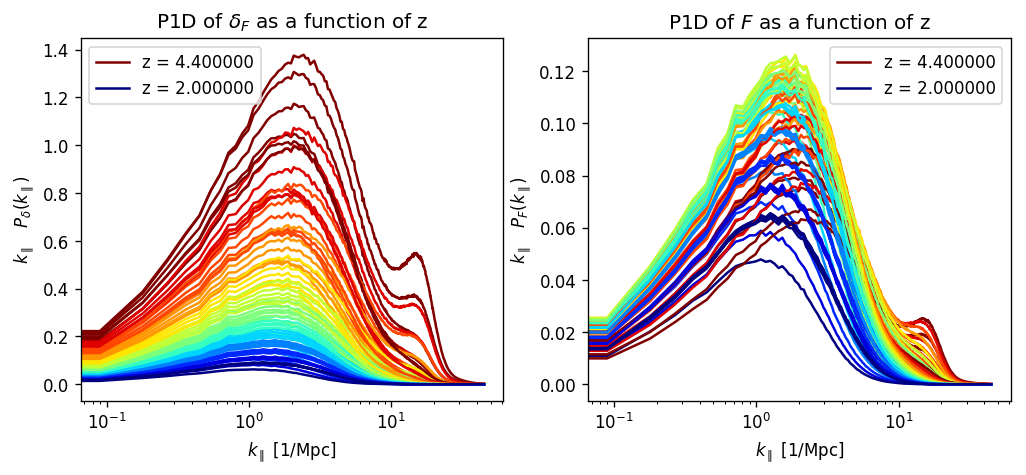

In [6]:
plot_p1d_dependence(arxiv_1806,'z')